In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Async API


Нам предстоит погрузиться в мир асинхронного программирования. Сейчас уже сложно представить Python без асинхронного подхода — он только набирает популярность среди веб-разработчиков. 

## Асинхронный подход

Сегодня мы изучим следующие темы:

- итераторы, генераторы и корутины
    - итераторы;
    - генераторы и корутины;
- асинхронность в Python и asyncio
    - асинхронное программирование;
    - event-loop;
    - asyncio;
- асинхронные фреймворки
    - twisted;
    - aiohttp;
    - fastapi;
- async API

## Итераторы

Разработчики используют итераторы в коде настолько часто, что даже не задумываются, в чём они помогают. Итераторы в Python — это списки, словари, множества, строки, файлы и другие коллекции. Везде, где вы пишете цикл `for`, используется итератор. Итераторы помогают перемещаться по объектам любого контейнера в коде. При этом вам не нужно задумываться о том, как хранятся и обрабатываются эти элементы: итератор инкапсулирует их. Проще говоря, это способ вычитывать элементы из объекта по одному.

Перейдём сразу к практике. Представим, что на собеседовании вас попросили реализовать аналог функции `range`.

In [13]:
class Range:
    def __init__(self, stop_value: int):
        self.current = -1
        self.stop_value = stop_value - 1
        
    def __iter__(self):
        return RangeIterator(self)
    

In [21]:
class RangeIterator:
    def __init__(self, container):
        self.container = container
  
    def __next__(self):
        if self.container.current < self.container.stop_value:
            self.container.current += 1
            return self.container.current
        raise StopIteration

Получили первую версию работающего кода. Запустим код и убедимся в этом.

In [22]:
_range = Range(5)

for i in _range:  # iter(_range)
    print(i) 

0
1
2
3
4


Что делает `for`:

In [25]:
range1 = Range(7)
iterator = iter(range1) # iter(range1)

In [17]:
iterator

In [18]:
next(iterator)

0

### «А как это работает? Расскажите подробнее»

Начнём с класса `Range`. У него внутри реализован магический метод `__iter__`. Он обозначает, что объект этого класса итерабельный, то есть с ним можно работать в цикле `for`. Ещё говорят, что `__iter__` отдаёт [итерируемый объект](https://docs.python.org/3.7/library/stdtypes.html#iterator.__iter__).

Ограничимся понятиями итератора и итерабельного объекта. Чтобы код действительно отдавал новые данные из `range`, нужно реализовать соответствующую функцию. Она как раз и называется итератор. `RangeIterator` — итератор для класса `range`. Любой итератор должен реализовывать магическую функцию `__next__`, в которой он должен отдавать новые значения для объектов класса `Range`. Если вы дошли до конца множества значений, то появляется исключение `StopIteration`.

Для тех, кто привык читать первоисточники, существует [PEP-234](https://www.python.org/dev/peps/pep-0234/) (на английском). Там подробно изложена работа итераторов и итерабельных объектов.

Но можно ли как-то упростить написанный выше код? Да, можно.

In [23]:
class Range2:
    def __init__(self, stop_value: int):
        self.current = -1
        self.stop_value = stop_value - 1

    def __iter__(self):
        return self

    def __next__(self):
        if self.current < self.stop_value:
            self.current += 1
            return self.current
        raise StopIteration 

В Python есть возможность объявить объекты класса и итерабельными, и итераторами. Это удобно, но с точки зрения принципов проектирования приложения, у такого объекта есть две ответственности: он является итератором и при этом выполняет какую-то свою логику. В мире Python это допустимо, но в некоторых других языках вас могут понять неправильно. Будьте бдительны!

Ещё стоит рассмотреть, как работает цикл `for` под капотом.

In [26]:
iterable = Range2(5)
iterator = iter(iterable)

while True:
    try:
        value = next(iterator)
        print(value)
    except StopIteration:
        break 

0
1
2
3
4


## Генераторы

Работа генераторов построена на принципе запоминания контекста выполнения функции. Если не вдаваться в подробности работы Python-интерпретатора, то функция-генератор «запоминает», на каком месте она остановилась, и может продолжить своё выполнение после ключевого слова `yield`.

Рассмотрим простой пример.

In [ ]:
def simple_generator():
    print("First yield")
    yield 1
    print("Second yield")
    yield 2
    return 3

Посмотрим, что будет, если вызвать такой код:

In [ ]:
gen = simple_generator()
print(type(gen))
print(next(gen))
print("CPU bound task")
print(next(gen))
print(next(gen))

<class 'generator'>
First yield
1
CPU bound task
Second yield
2
not items


То есть функция действительно запоминает, где она остановилась после каждого вызова функции `next`.

Генераторы удобны и для создания генераторных выражений — `generator expressions`. Особенно это полезно, если нужно сгенерировать много объектов, а память расходовать жалко. Код выглядит так:

In [ ]:
gen_exp = (x for x in range(100_000)) # это не кортеж
print(gen_exp)

<generator object <genexpr> at 0x711fdc1d1c00>
4999950000


Есть ещё небольшой синтаксический сахар, связанный с генераторами. Представим функцию, внутри которой есть цикл по элементам списка, и они выводятся один за другим.

In [38]:
numbers = [1, 2, 3]
def func():
    for item in numbers:
        yield item

with open('out.txt', 'w') as file:
  for item in func(): # iter(func()) -> next(func())
    print(item, file=file)


За счёт генератора конструкция сокращается до такой:

In [39]:
def func():
    yield from numbers

Бывает очень полезно, но на практике используется довольно редко.

## Корутины

Затронем тему корутин — основных строительных блоков асинхронного программирования на Python. Они появились в ответ на невозможность использования полноценного распараллеливания программы с помощью тредов (потоков) из-за работы `GIL`. Для тех, кому интересно узнать подробнее про `Global Interpreter Lock`, есть хорошая обзорная [статья](https://tproger.ru/translations/global-interpreter-lock-guide/).

Корутина — это генератор. Однако в [PEP-342](https://www.python.org/dev/peps/pep-0342/) предложили расширить возможности генераторов, добавив туда несколько конструкций, о которых сейчас пойдёт речь.

Представьте себе метод, который на вход получает какое-то значение, как-то его обрабатывает и отдаёт результат. Пусть это будет функция, рассчитывающая количество денег на вашем счете через $N$ лет при определённом проценте. На вход функция принимает процент по депозиту в годовых и сумму на счёте.

In [40]:
import math

def cash_return(deposit: int, percent: float, years: int) -> float:
    value = math.pow(1 + percent / 100, years)
    return round(deposit * value, 2)

Теперь узнаем, сколько вы получите денег через $5$ лет, если сумма на депозите — $1 000 000$ рублей, а ставка по депозиту — $5%%$ годовых.

In [41]:
cash_return(1_000_000, 5, 5)

1276281.56

Теперь вы хотите посмотреть на то, как будет меняться итоговая сумма в зависимости от депозита. Тут приходит на помощь корутина.

In [ ]:
import math

def cash_return_coro(percent: float, years: int) -> float:
    value = math.pow(1 + percent / 100, years)
    while True:
        try:
            deposit = (yield) # 1. Остановился. 2 Получил значение, которое мы отправили с помощью метода .send()
            yield round(deposit * value, 2)
        except GeneratorExit:
            print('Выход из корутины')
            raise

Запустим корутину с теми же условиями — $5$ лет и $5%%$ годовых.

In [47]:
coro = cash_return_coro(5, 5)
next(coro)
values = [1000, 2000, 5000, 10000, 100000]
for item in values:
    print(coro.send(item))
    next(coro)
coro.close() 

1276.28
2552.56
6381.41
12762.82
127628.16
Выход из корутины


Разберёмся, что произошло. В коде видно четыре новых конструкции: `(yield)`, `send(...)`, `close()` и `GeneratorExit`. Корутины могут не только отдавать значения и запоминать место, где остановился код, но и ждать новых значений. Для этого ввели конструкцию `(yield)`, которая позволяет принимать набор параметров. Так как приём параметров в корутине происходит необычным способом, то и отправка параметров сделана с помощью специальной функции `send(...)`, через которую можно передать в функцию необходимые параметры. В конце ещё можно вызвать метод `close()`, который прекратит выполнение корутины. Когда вы вызываете метод `close()`, выбрасывается исключение `GeneratorExit`, которое можно перехватить и грамотно обработать.

Ещё одно преимущество — возможность запомнить контекст выполнения. В функции `cash_return_coro` нет необходимости вычислять переменную `value` каждый раз, когда вы хотите посчитать сумму. Недостатком такого подхода можно назвать большее количество кода, который надо написать, чтобы всё могло грамотно работать.

In [ ]:
# Корутины ил сопрограммы

# Инициализирующий декоратор
def coroutine(func):
    def inner(*args, **kwargs):
        g = func(*args, **kwargs)
        g.send(None)
        return g
    return inner


def subgen():
    x = "Ready to accept message"
    message = yield x  # двусторонняя структура, может принимать, может отдавать
    print('Subgen received:', message)

    

In [22]:
g = subgen()
# g.send('hello') # Error

from inspect import getgeneratorstate
print(getgeneratorstate(g))

g.send(None) # Инициализация генератора. Можно использовать next(g)
getgeneratorstate(g)


GEN_CREATED


'Ready to accept message'

'GEN_SUSPENDED'

In [ ]:
class SomeException(Exception):
    pass


@coroutine
def average_gen():
    count = summ = 0
    average = None

    while True:
        try:
            x = yield average
        except StopIteration:
            print("Done")
            break
        except SomeException:
            print('====== SomeException =====')
            break
        else:
            count += 1
            summ += x
            average = round(summ / count, 2)
    
    return average

In [ ]:
# Пример кода для return в генераторе
# Мы можем получить значение из e.value
g = average_gen()
g.send(4)
g.send(6)
g.send(8)
try:
    g.throw(SomeException)
except StopIteration as e:
    print("Average:", e.value)



average = None


4.0

average = 4.0


5.0

average = 5.0


6.0

====== SomeException =====
Average: 6.0


## Асинхронное программирование

Асинхронное программирование в мире Python-разработки на пике популярности. Про него пишут статьи и делают доклады на конференциях. Концепция уже прижилась и во многих других популярных языках. Давайте восполним пробелы и погрузимся в работу с асинхронным кодом на Python.

### Работа с разными типами задач

Раньше разработчики не сильно заостряли своё внимание на типе выполняемых задач внутри приложения — это было не нужно для индустрии в целом. Все писали достаточно большие монолитные приложения, а проблемы с производительностью обычно решались на уровне горизонтального масштабирования: через потоки, процессы или даже через несколько приложений на разных виртуальных машинах.

Сейчас использование только процессов и потоков не даёт нужной производительности. Рассмотрим три основных типа задач, с которыми сталкивается большинство разработчиков:

- **CPU bound-задачи.** Задачи, для которых необходимо интенсивное использование процессора. К ним относят использование сложных математических моделей, обучение нейронных сетей, рендеринг графики и вычисление хэшей.

- **I/O bound-задачи (non-RAM I/O bound).** Задачи, в которых основная часть работы приходится на ввод/вывод информации *I/O* или *input/output*. В основном такие задачи относятся к работе с файловой системой и с сетью. 

- **Memory bound-задачи (RAM I/O bound).** Задачи, в которых происходит интенсивная работа с оперативной памятью. Как правило, такие задачи появляются в сложных математических моделях. Из-за медленной работы с оперативной памятью всё больше моделей обрабатывают с помощью видеокарт, в которых работа с памятью устроена по-другому. Другой пример — обработка огромного объёма данных в *Map-Reduce*-системах, например, таких как *Spark*. Обработка будет идти быстрее, если оперативной памяти будет больше.

Подробнее об этом можно прочитать в англоязычных статьях: - [о значении терминов CPU bound и I/O bound](https://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean), - [о производительности](https://link.springer.com/chapter/10.1007/978-1-4842-4932-1_15).

Из-за массового перехода на микросервисы количество сетевого взаимодействия между системами многократно возросло, как и нагрузка на базы данных. Проблемы работы с сетью или с доступом к БД относятся к I/O bound-задачам. То есть их основная работа — ожидание обработки запроса к внешней системе. Такой класс задач в монолитных системах решался пулом потоков — [thread pool](https://en.wikipedia.org/wiki/Thread_pool). Однако, его стало не хватать из-за достаточно интенсивной нагрузки на сеть между множеством сервисов.

Классический метод решения I/O bound задач — добавление ресурсов к существующим системам. Однако, многие компании не могут позволить себе «заливать всё железом» — докупать новые железные серверы, вместо оптимизации кода. Например, Instagram может себе такое позволить, поэтому они до сих пор используют Django даже с учётом всей нагрузки.

Перейдём к практике. Представьте приложение, которое ходит на некий сайт-агрегатор, достаёт данные по фильмам и сохраняет в БД. Код будет выглядеть так (ссылка на сайт выдуманная):

In [23]:
import requests

def do_some_logic(data):
    pass
  
def save_to_database(data):
    pass

data = requests.get('https://data.aggregator.com/films')
processed_data = do_some_logic(data)
save_to_database(data)

ConnectionError: HTTPSConnectionPool(host='data.aggregator.com', port=443): Max retries exceeded with url: /films (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d280c60b590>: Failed to resolve 'data.aggregator.com' ([Errno -2] Name or service not known)"))

Этот код достаточно линейный. Если вместо загрузки фильмов в БД такой код будет выполнять отдачу данных о фильмах с этого же сайта, то при достаточной нагрузке приложение начнёт сильно проседать по скорости ответа клиентам. При этом бо́льшую часть времени код будет просто ждать запроса от клиента, делать запрос к сайту https://data.aggregator.com/films и отдавать данные. То есть в эти моменты интерпретатор не будет делать никаких полезных действий, а клиенты будут ждать.

Схематично изобразить выполнение программы можно вот так:

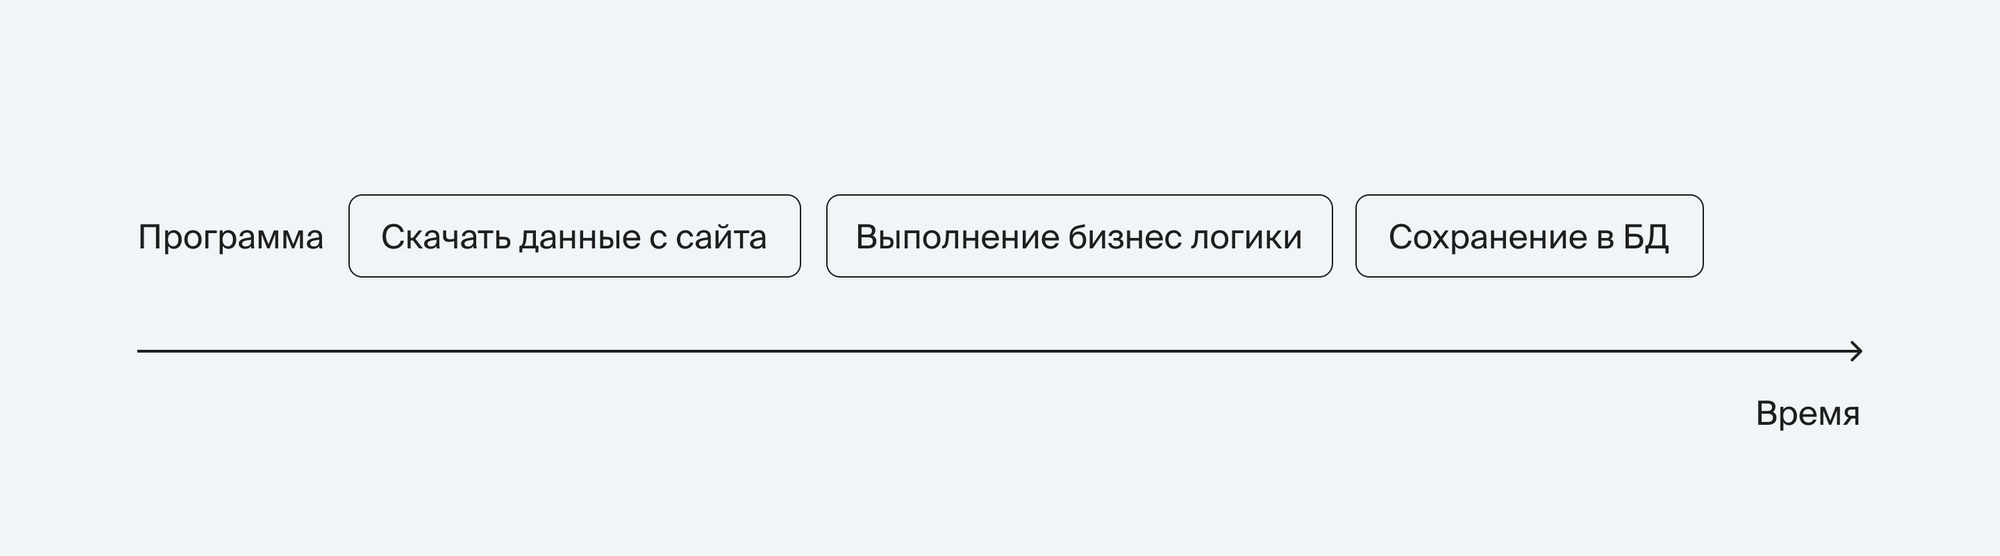

Теперь определим тип задачи в каждой ячейке:

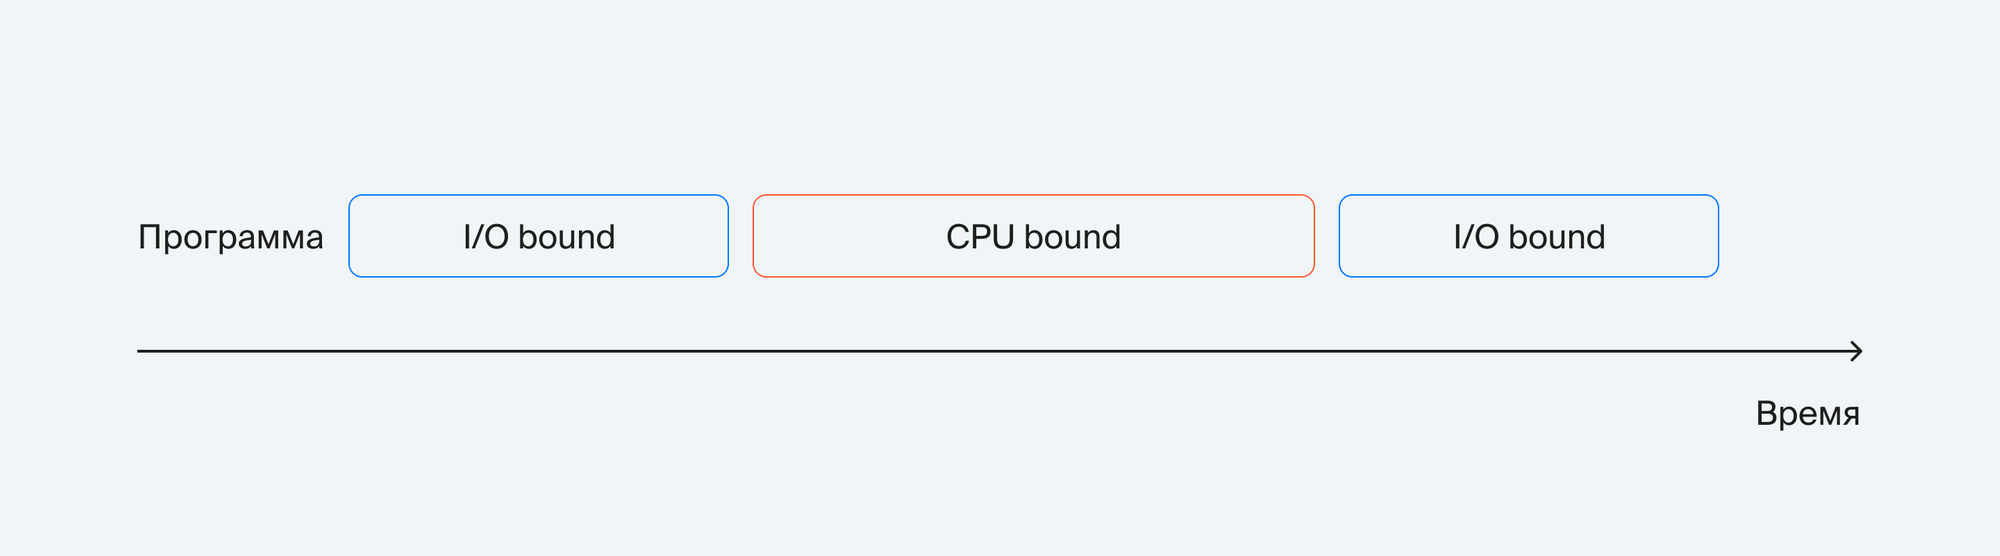

Интуитивно выполнение программы кажется примерно таким, как указано на картинке выше. 

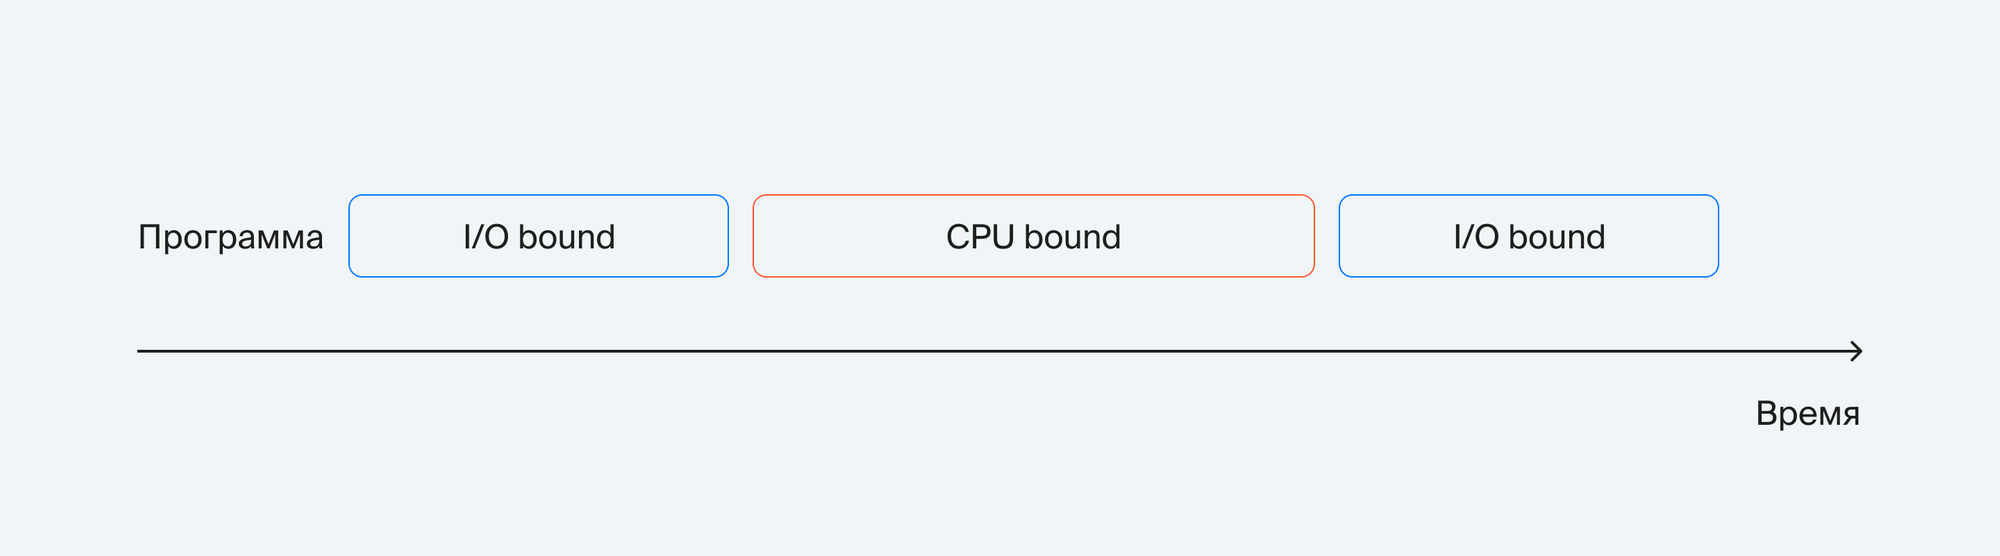

Однако, если привести картинку в соответствие с реальностью, получим следующий результат:

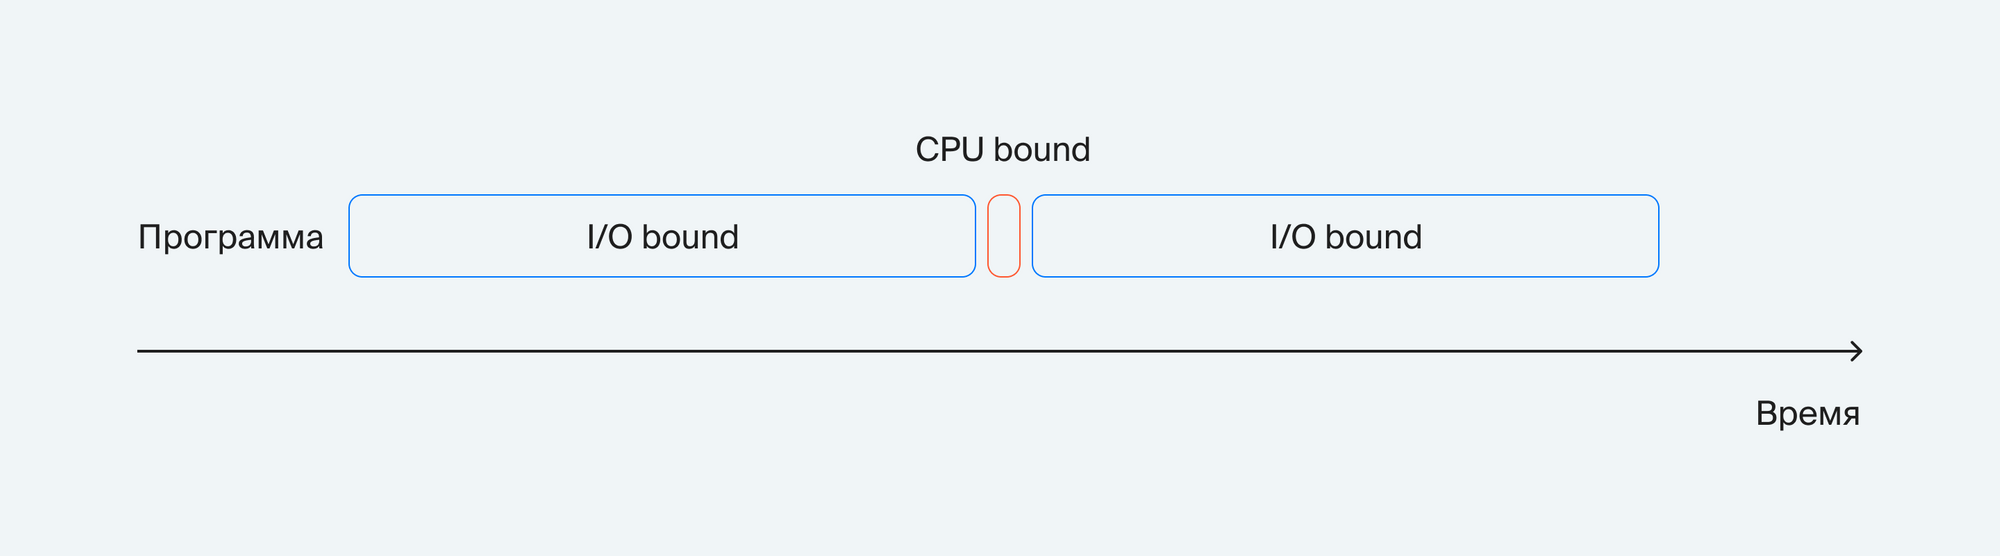

То есть бо́льшую часть времени программа ждёт ввода/вывода, а меньшая часть времени отводится на выполнение полезной работы.
Эту проблему можно решить, распараллелив код на процессы и потоки. Такой вариант поможет, но на короткое время — при таком подходе сильно увеличатся расходы ресурсов сервера. Плюс количество допустимых процессов и потоков ограничено. То есть либо закончится оперативная память под потоки, либо закончатся ядра под процессы. Вишенкой на торте становится `GIL`, который даёт работать только одному потоку в единицу времени. Это не позволяет эффективно использовать массовый параллелизм на потоках и добавляет свои накладные расходы, хоть и не очень заметные.

Посмотрим, как применение потоков сказывается на выполнении программы:

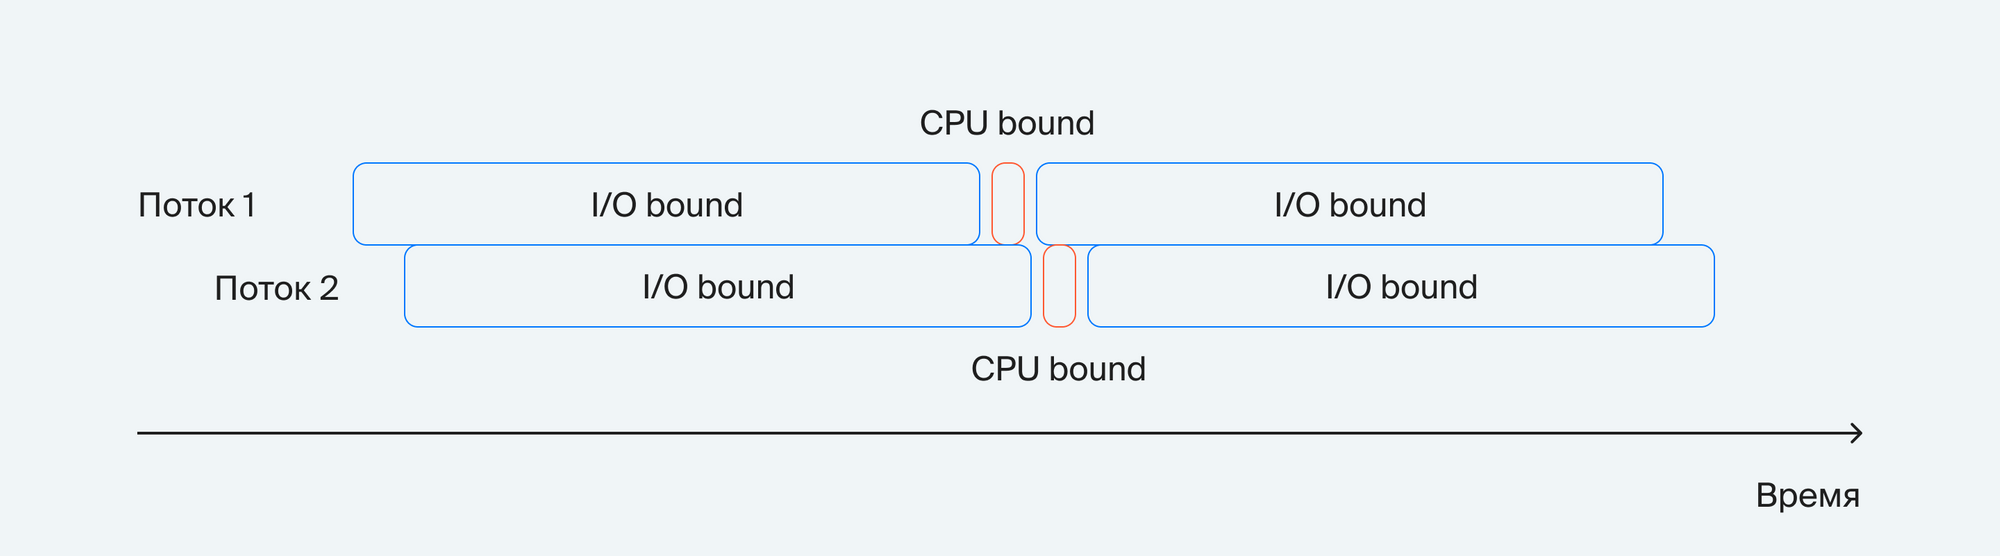

Действительно, два потока почти в два раза лучше отрабатывают I/O bound задачи. Но к сожалению, при таком подходе очень просто ошибиться и столкнуться с проблемой [«состояния гонок»](https://ru.wikipedia.org/wiki/Состояние_гонки). Можно попробовать вариант с корутинами, но его сложнее реализовать. И при таком способе не получится создать много потоков, так как они потребляют гораздо больше ОЗУ, чем корутины. Также написание многопоточного кода требует от разработчика большей внимательности, чем при написании линейного.

Стоит внимательнее присмотреться к проблеме. Всё ещё бо́льшую часть времени интерпретатор не совершает активных действий, а только ждёт ответа от ОС, завершилась ли та или иная операция ввода/вывода. В целом процессы и потоки не сильно помогут, ведь интерпретатор будет по-прежнему простаивать на каждом из них. При этом появится много накладных расходов на переключение контекста между процессами или на потребление оперативной памяти потоками, что может только ухудшить положение.


Все эти проблемы необходимо решать эффективно. С этим может помочь использование асинхронного кода.

## Event-loop

Итак, вы добрались до сердца асинхронных программ в Python — цикла событий. Чтобы понять, как он работает, обратимся к простой реализации, которую предложил Девид Бизли (David Beazley) [в 2009 году](http://www.dabeaz.com/coroutines/Coroutines.pdf). Она хороша тем, что не содержит сложных конструкций, которыми сейчас обросли популярные реализации цикла событий на Python. Эта часть будет построена на разборе кода и практик, которые применяются для разработки цикла событий на основе [кода Бизли](http://www.dabeaz.com/coroutines/pyos8.py), и как учитывать эти знания при разработке асинхронных приложений на Python. Код уже приведён к современной версии Python.

Начнём с архитектуры цикла событий.

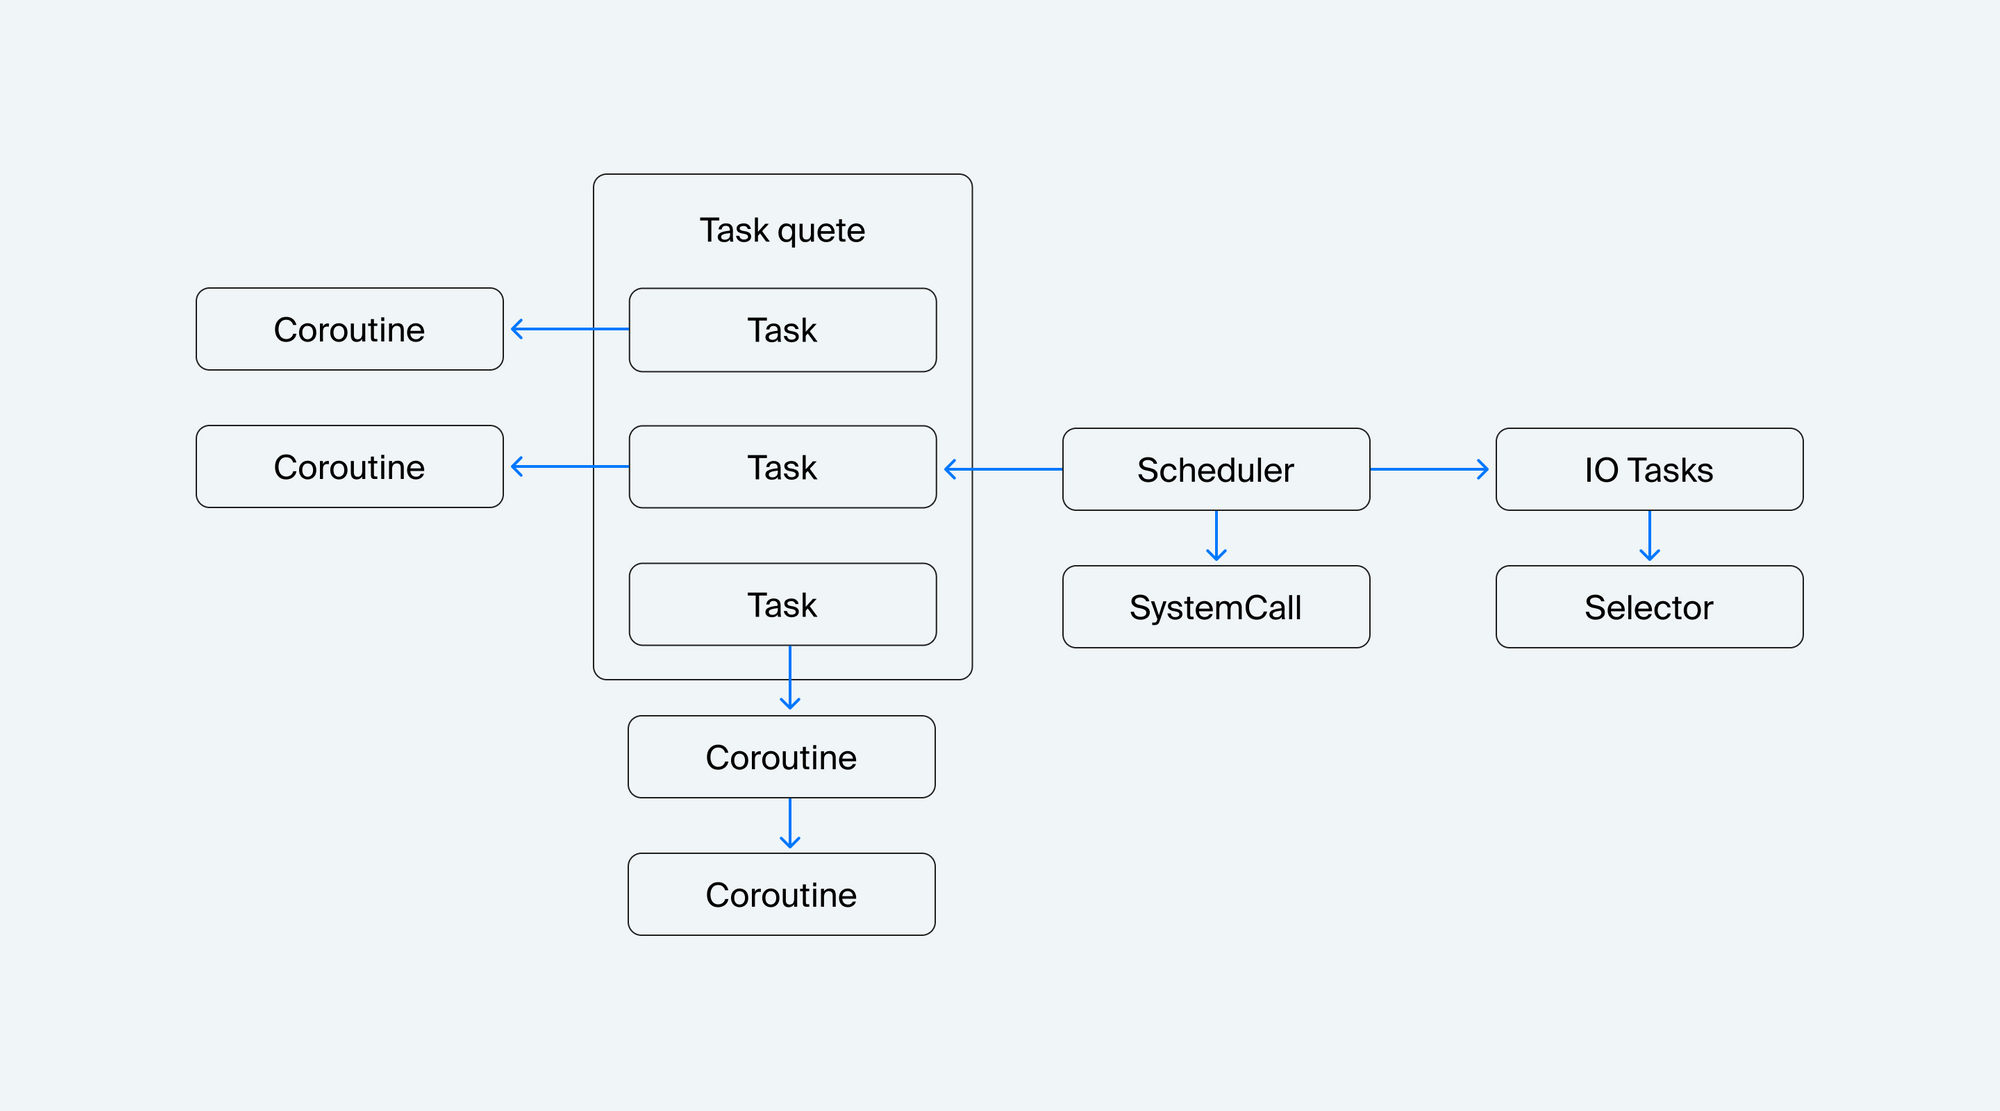

Расмотрим блоки:

- **Планировщик (Scheduler)**. Корень всей программы. Обрабатывает задачи в очереди задач и следит за их правильным переключением между собой.
- **Очередь задач (Task queue)**. Здесь собираются новые задачи на исполнение.
- **Задача (Task)**. Основной блок работы цикла событий. В задачах хранится информация о выполняемой корутине. Умеет обрабатывать цепочку вложенных корутин.
- **Корутина (Coroutine)**. Исполняемый код, которым оперирует планировщик задач.
- **Системный вызов (SystemCall)**. Блоки кода, которые расширяют функциональность планировщика.
- **Корутина для выполнения работы с I/O (I/O-tasks)**. В планировщик добавляется специальная задача (Task) для обработки I/O-событий от ОС.
- **Селектор (Selector)**. Он слушает события от ОС и передаёт работу корутинам, которые ждут обработки I/O-сообщений.

Первым стоит рассмотреть работу планировщика. Его основные функции — приём и справедливая обработка списка задач.

In [26]:
import logging
from typing import Generator
from queue import Queue


class Scheduler:
    def __init__(self):
        self.ready = Queue()
        self.task_map = {}

    def add_task(self, coroutine: Generator) -> int:
        new_task = Task(coroutine)
        self.task_map[new_task.tid] = new_task
        self.schedule(new_task)
        return new_task.tid

    def exit(self, task: Task):
        del self.task_map[task.tid]

    def schedule(self, task: Task):
        self.ready.put(task)

    def _run_once(self):
        task = self.ready.get()
        try:
            result = task.run()
        except StopIteration:
            self.exit(task)
            return
        self.schedule(task)

    def event_loop(self):
        while self.task_map:
            self._run_once()

Вся работа происходит в функции `event_loop()`, которая просто достаёт задачи одну за другой. В функции `_run_once()` идёт обработка итерации цикла событий, в которой поочерёдно берутся и запускаются задачи для обработки. Если задача не завершилась, то она ставится заново в очередь задач `self.ready`. Выполненные задачи нужно убрать из планировщика функцией `exit()`.

Для добавления задачи используйте функцию `add_task()`. Она принимает корутину для выполнения и создаёт с ней задачу в планировщике. Чтобы поставить задачу напрямую в планировщик, необходимо вызвать функцию `schedule()`.

Далее разберёмся с устройством задачи.

In [29]:
import types
from typing import Generator, Union

class Task:
    task_id = 0

    def __init__(self, target: Generator):
        Task.task_id += 1
        self.tid = Task.task_id  # Task ID
        self.target = target  # Target coroutine
        self.sendval = None  # Value to send
        self.stack = []  # Call stack

    # Run a task until it hits the next yield statement
    def run(self):
        while True:
            try:
                result = self.target.send(self.sendval)

                if isinstance(result, types.GeneratorType):
                    self.stack.append(self.target)
                    self.sendval = None
                    self.target = result
                    print("result is next goroutine")
                    print(result.__name__)
                else:
                    if not self.stack:
                        return
                    self.sendval = result
                    self.target = self.stack.pop()
                    print(f'{self.target.__name__}')

            except StopIteration:
                if not self.stack:
                    raise
                self.sendval = None
                self.target = self.stack.pop()

Сама по себе задача — обёртка над корутиной. У каждой задачи есть свой `id`, который учитывается в планировщике в словаре `task_map`. На его заполненность смотрит планировщик при выполнении задач.

Другая особенность задач — возможность выполнения корутин методом `run()`. Давайте посмотрим, как они выполняются в рамках задачи. Предположим, что есть корутина, которая вызывает другую корутину, а та — третью. Например, вот такой код:

In [30]:
def double(x):
    yield x * x

def add(x, y):
    yield from double(x + y)

def main():
    result = yield add(1, 2)
    print(result)
    yield

Код является небольшой модификацией [кода Бизли](http://www.dabeaz.com/coroutines/trampoline.py) из его выступления. Теперь попробуем выполнить эту цепочку корутин в рамках `Task`.

In [31]:
task = Task(main())
task.run()

result is next goroutine
add
main
9


Таким же образом будут выполняться и остальные корутины в рамках планировщика. Осталось только расширить планировщик для работы с I/O-операциями.

В рамках планировщика добавляем специальную бесконечную задачу `io_task` перед стартом цикла событий. Эта функция имеет бесконечный цикл внутри и передаёт управление планировщику после вызова выполненных событий из селектора.

In [ ]:
import logging
from typing import Generator, Union
from queue import Queue
from selectors import DefaultSelector, EVENT_READ, EVENT_WRITE


logger = logging.getLogger(__name__)


class Scheduler:
    def __init__(self):
        self.ready = Queue()
        self.selector = DefaultSelector()
        self.task_map = {}

    def add_task(self, coroutine: Generator) -> int:
        new_task = Task(coroutine)
        self.task_map[new_task.tid] = new_task
        self.schedule(new_task)
        return new_task.tid

    def exit(self, task: Task):
        logger.info('Task %d terminated', task.tid)
        del self.task_map[task.tid]

    # I/O waiting
    def wait_for_read(self, task: Task, fd: int):
        try:
            key = self.selector.get_key(fd)
        except KeyError:
            self.selector.register(fd, EVENT_READ, (task, None))

        else:
            mask, (reader, writer) = key.events, key.data
            self.selector.modify(fd, mask | EVENT_READ, (task, writer))

    def wait_for_write(self, task: Task, fd: int):
        try:
            key = self.selector.get_key(fd)
        except KeyError:
            self.selector.register(fd, EVENT_WRITE, (None, task))

        else:
            mask, (reader, writer) = key.events, key.data
            self.selector.modify(fd, mask | EVENT_WRITE, (reader, task))

    def _remove_reader(self, fd: int):
        try:
            key = self.selector.get_key(fd)
        except KeyError:
            pass
        else:
            mask, (reader, writer) = key.events, key.data
            mask &= ~EVENT_READ
            if not mask:
                self.selector.unregister(fd)
            else:
                self.selector.modify(fd, mask, (None, writer))

    def _remove_writer(self, fd: int):
        try:
            key = self.selector.get_key(fd)
        except KeyError:
            pass
        else:
            mask, (reader, writer) = key.events, key.data
            mask &= ~EVENT_WRITE
            if not mask:
                self.selector.unregister(fd)
            else:
                self.selector.modify(fd, mask, (reader, None))

    def io_poll(self, timeout: Union[None, float]):
        events = self.selector.select(timeout)
        for key, mask in events:
            fileobj, (reader, writer) = key.fileobj, key.data
            if mask & EVENT_READ and reader is not None:
                self.schedule(reader)
                self._remove_reader(fileobj)
            if mask & EVENT_WRITE and writer is not None:
                self.schedule(writer)
                self._remove_writer(fileobj)

    def io_task(self) -> Generator:
        while True:
            if self.ready.empty():
                self.io_poll(None)
            else:
                self.io_poll(0)
            yield

    def schedule(self, task: Task):
        self.ready.put(task)

    def _run_once(self):
        task = self.ready.get()
        try:
            result = task.run()
        except StopIteration:
            self.exit(task)
            return
        self.schedule(task)

    def event_loop(self):
        self.add_task(self.io_task())
        while self.task_map:
            self._run_once()

Код значительно разросся, но на самом деле ничего страшного не произошло. Рассмотрим изменения в порядке вызовов. В рамках планировщика добавляем специальную бесконечную задачу `io_task` перед стартом цикла событий. Эта функция имеет бесконечный цикл внутри и передаёт управление планировщику после вызова выполненных событий из селектора.

Рассмотрим подробнее устройство `io_task`. Если очередь задач пустая, то timeout для ожидания событий из селектора ставится в режим «до тех пор, пока не будет новых событий». В остальных случаях ставим таймаут 0, чтобы получить все события от ОС сразу же. Такую особенность работы этого метода рассмотрим чуть позже.

Если из селектора пришли новые события, то обрабатываем их и убираем из обработки файловые дескрипторы. Важный момент — хранение данных о задачах в селекторе. Одна и та же задача может ожидать чтения данных и пытаться записать новые данные. Именно поэтому в поле `data` хранится кортеж `(reader, writer)`.

По сути, `event_loop` должен предоставлять интерфейс для работы с сокетами. Таких метода всего четыре:
- `wait_for_read`,
- `wait_for_write`,
- `_remove_reader`,
- `_remove_writer`.

Эти методы позволяют работать с циклом событий, встроенным в ОС.

Работа с I/O для цикла событий — «пристройка сбоку» для обработки сетевых запросов. То есть основное назначение цикла событий в Python — обработка функций корутин, которые могут никуда не ходить по сети, а работать только с файловой системой.

Осталось разобраться с конструкцией `SystemCall`. Так как изначально цикл событий больше напоминает работу ОС, должен быть механизм прерываний, чтобы передать управление ОС. В асинхронном коде прерывание обеспечивается с помощью `yield`. После переключения контекста может вызываться системная функция для исполнения. Например, для создания новых задач можно использовать вот такой код:

In [32]:
class SystemCall:
    def handle(self, sched: Scheduler, task: Task):
        pass


class NewTask(SystemCall):
    def __init__(self, target: Generator):
        self.target = target

    def handle(self, sched: Scheduler, task: Task):
        tid = sched.add_task(self.target)
        task.sendval = tid
        sched.schedule(task)

В `Scheduler` достаточно добавить небольшой фрагмент кода:

In [33]:
class Scheduler:
    ...
    def _run_once(self):
        task = self.ready.get()
        try:
            result = task.run()
            if isinstance(result, SystemCall):
                result.handle(self, task)
                return
        except StopIteration:
            self.exit(task)
            return
        self.schedule(task)

А в `Task` добавляем небольшое условие при выполнении корутин:

In [ ]:
import types
from typing import Generator, Union

class Task:
    ...
    def run(self):
        while True:
            try:
                result = self.target.send(self.sendval)
                if isinstance(result, SystemCall):
                    return result
                ...

Что всё это значит? Разберёмся на примере `NewTask`. Этот класс предоставляет интерфейс для создания новых задач в цикле событий. Такой интерфейс позволяет абстрагировать клиентский код. Это эмуляция защищённой среды ОС, когда последняя предоставляет безопасные методы для работы с ядром. Такие методы не дают клиентскому коду мешать другим программам в ОС. Таким же образом можно сделать `KillTask` или `WaitTask`.

Осталась последняя проблема — блокирующие операции. Из-за них код не может асинхронно обрабатывать события и цикл событий ждёт выполнения на каждой функции. Есть вариант решения проблемы:

- Сделать неблокирующими сокеты через `socket.setblocking(False)`.

## Asyncio

Теперь у нас достаточно знаний, чтобы без труда освоить основную встроенную библиотеку для асинхронного программирования — `asyncio`.

С версии Python 3.5 в язык добавили специальный синтаксис — async/await. Он позволяет использовать «нативные» корутины, которые теперь являются частью языка. Они разделяют генераторы от асинхронного кода, что позволяет создавать асинхронные генераторы и ускорять работу асинхронного кода.


Посмотрим, как выглядит простая программа с использованием async/await.

In [34]:
import random
import asyncio
# для запуска в Jupyter Notebook необходима дополнительная библиотека
# pipenv install nest_asyncio
import nest_asyncio
nest_asyncio.apply()


async def func():
    r = random.random()
    await asyncio.sleep(r)
    return r


async def value():
    result = await func()
    print(result)

    

if __name__ == '__main__':
    loop = asyncio.new_event_loop()
    loop.run_until_complete(value())
    loop.close()

0.11789986748389869


В целом изменений немного. Переменная `loop` — это не что иное, как планировщик задач. Он работает по схожим принципам с тем, что рассматривался ранее. Теперь все функции переключаются с помощью `await`.

Познакомимся с основными функциями `asyncio`, которые часто встречаются на практике:

- `gather` — выполняет список корутин одновременно и дожидается результата выполнения всех корутин.
- `sleep` — заставляет корутину уснуть на определённое количество секунд.
- `wait`/`wait_for` — удобные функции, чтобы дождаться выполнения уже запущенной корутины.

Также стоит ознакомиться с основными функциями `event_loop`:

- `get_event_loop` — получить новый объект `event_loop` или тот, что уже существует. При этом одновременно может существовать только один объект `event_loop`.
- `run_until_complete`/`run` — удобные функции для запуска и проверки асинхронных функций.
- `shutdown_asyncgens` — одна из самых недооценённых функций цикла событий, которая позволяет правильно завершить выполнение цикла событий и всех корутин.
- `call_soon` — позволяет запланировать выполнение корутины, но не ждать её выполнения. Таким образом можно вечно ставить на выполнение одну и ту же функцию.

Теперь стоит поговорить про ключевые различия между asyncio и предложенной реализацией цикла событий. Asyncio работает на функциях обратного вызова или колбэках (callback). Этот механизм запускает задачи «честнее», чем текущий планировщик. Каждая корутина по-честному ставится в очередь и исполняется. В простом планировщике переключения не произойдёт, пока вся цепочка корутин не выполнится, что блокирует выполнение остальных задач. Однако, у колбэков есть и свой недостаток — callback hell. Это состояние, когда после вызова каждой функции нужно вызвать ещё одну функцию и ещё одну функцию... Получаются интересные фрагменты кода:

In [ ]:
func1.add_callback(
    func2.add_callback(
                func3.add_callback(func4)
        )
) 

К счастью, этого удаётся избежать через синтаксис async/await.

In [ ]:
await func4()
await func3()
await func2()
await func1() 

Такое поведение возможно благодаря введению класса `Future`. По сути, такие объекты спасают от колбэков и делают код более линейным. В современных версиях Python `Future`-объекты для нативных корутин не нужны.

## Асинхронные фреймворки

В прошлых уроках мы познакомились с областями применения асинхронного программирования в Python и его реализацией. 

Теперь познакомимся с тремя фреймворками:

- `Twisted` — один из старейших. 
- `AIOHTTP` — самый нативный. 
- `FastAPI` — самый узкоспециализированный.

Разумеется, их гораздо больше. Но пока начнём с малого.

### Почему мы пока не должны использовать Django

Несмотря на то что Django 3.х гордо называет себя асинхронным фреймворком, большинство его кода, включая ORM, всё ещё работает в синхронном режиме. Создатели фреймворка медленно, но уверенно идут к поддержке асинхронности, хотя сама асинхронность в этом фреймворке — скорее дополнение, чем основной путь разработки. В Django работают оба режима — синхронный и асинхронный. У фреймворка есть возможность переключаться между ними в случае необходимости.

Во второй версии Django проблема с I/O-bound-операциями решалась при помощи [Django-Channels](https://channels.readthedocs.io/en/latest/). Эта библиотека расширила возможности Django, позволив разработчикам асинхронно обрабатывать HTTP-соединения и веб-сокеты. Для этого был добавлен абстрактный слой между работой с асинхронными соединениями и синхронным Django. На основе данных, полученных из асинхронных соединений, выполняются необходимые синхронные задачи.

`Django-Channel` разделён на нескольких сущностей:

- Канал (Channel) — это очередь событий, в которую поступают данные из соединения. Вы можете создать любое количество каналов, привязав их к URL в классическом для Django стиле. При возникновении нового события, например, установки соединения или получения данных, информацию получат все потребители.

- Потребитель (Consumer) — привязан к одному каналу или целой группе. Он умеет прослушивать поступающие сообщения и реагировать на них нужным образом. Каждому потребителю известно, из какого канала пришло сообщение.

Пример создания простого приложения можно найти в [документации](https://channels.readthedocs.io/en/latest/tutorial/index.html).

Под капотом Channels используется ASGI-сервер `Daphne`, написанный на `Twisted`. Давайте узнаем о нём побольше.

### Twisted

Во времена древних богов, воителей и королей до популяризации асинхронных фреймворков и до появления в Python собственной реализации event-loop, простой народ искал защитника. Одним из первых асинхронных инструментов был [Twisted](https://twistedmatrix.com/trac/).

На самом деле это было не так уж давно: этот проект относительно недавно достиг совершеннолетия!

Twisted — не просто веб-фреймворк для создания сайтов. Это набор модулей на все случаи жизни для написания любых клиентских или серверных веб-приложений. Также у него есть реализация GUI.


#### Основные концепции

Twisted состоит из нескольких ключевых понятий:

1 **Protocol**. 

Протоколы описывают, как приложение будет получать и отдавать данные. В Twisted реализовано [много готовых протоколов для работы с сетью](https://twistedmatrix.com/documents/current/api/twisted.protocols.html). Каждый объект протокола обязательно реализует метод, создающий соединение, и три метода-коллбека, которые вызываются:
- при создании соединения,
- при завершении соединения,
- при получении сообщения. В зависимости от целей вы можете написать любые обработчики поступающих данных.

2 **Factory.**

Класс, который отвечает за конфигурацию, управление и создание объектов протокола на каждое соединение. Здесь располагается код, который отвечает за поведение программы при неуспешной попытке соединения или его потере.

3 **Reactor.** 

Это собственная реализация event-loop в Twisted — сердце любого Twisted-приложения. Объект реактора не создаётся явно, а просто импортируется из библиотеки. После вызова `reactor.run()` он будет отвечать за весь цикл событий в потоке:
- появилось новое соединение и нужно задействовать фабрику для создания нового объекта протокола;
- на соединение в протоколе поступили данные;
- наступило время, на которое было назначено выполнение отложенной функции;
- соединение разорвалось, поэтому информация о событии передаётся в соответствующий протокол.

4 **Deffered-объекты.**

Отличительная и самая узнаваемая черта Twisted. Они нужны для формирования цепочки обратных вызовов. Рассмотрим их работу на примере:

In [ ]:
def toInt(data):  # Первый обработчик превращает данные в int
    return int(data)

def increment_number(data):  # Второй обработчик увеличивает значение на единицу
    return data + 1

def print_result(data):  # Третий обработчик выводит данные в консоль
    print(data)

def handleFailure(f):  # Обработчик ошибок
    print("OOPS!")

def get_deffered():
    # Объявляем Deffered-объект
    d = defer.Deferred()
    
    # Добавляем обработчики в нужном порядке
    return d.addCallbacks(toInt, 
                          handleFailure).addCallbacks(increment_number, 
                                                      handleFailure).addCallback(print_result)

Deffered-объект будет ожидать поступления данных, а после их обработки передаст выполнение одному из коллбеков. Они бывают двух видов: обработчики данных — callback и обработчики ошибок — errback. Callback принимает входные данные, а errback — объект Failure, состоящий из возникшего Exception и traceback. Twisted выполнит всю цепочку, выбирая в каждой паре коллбеков подходящий.

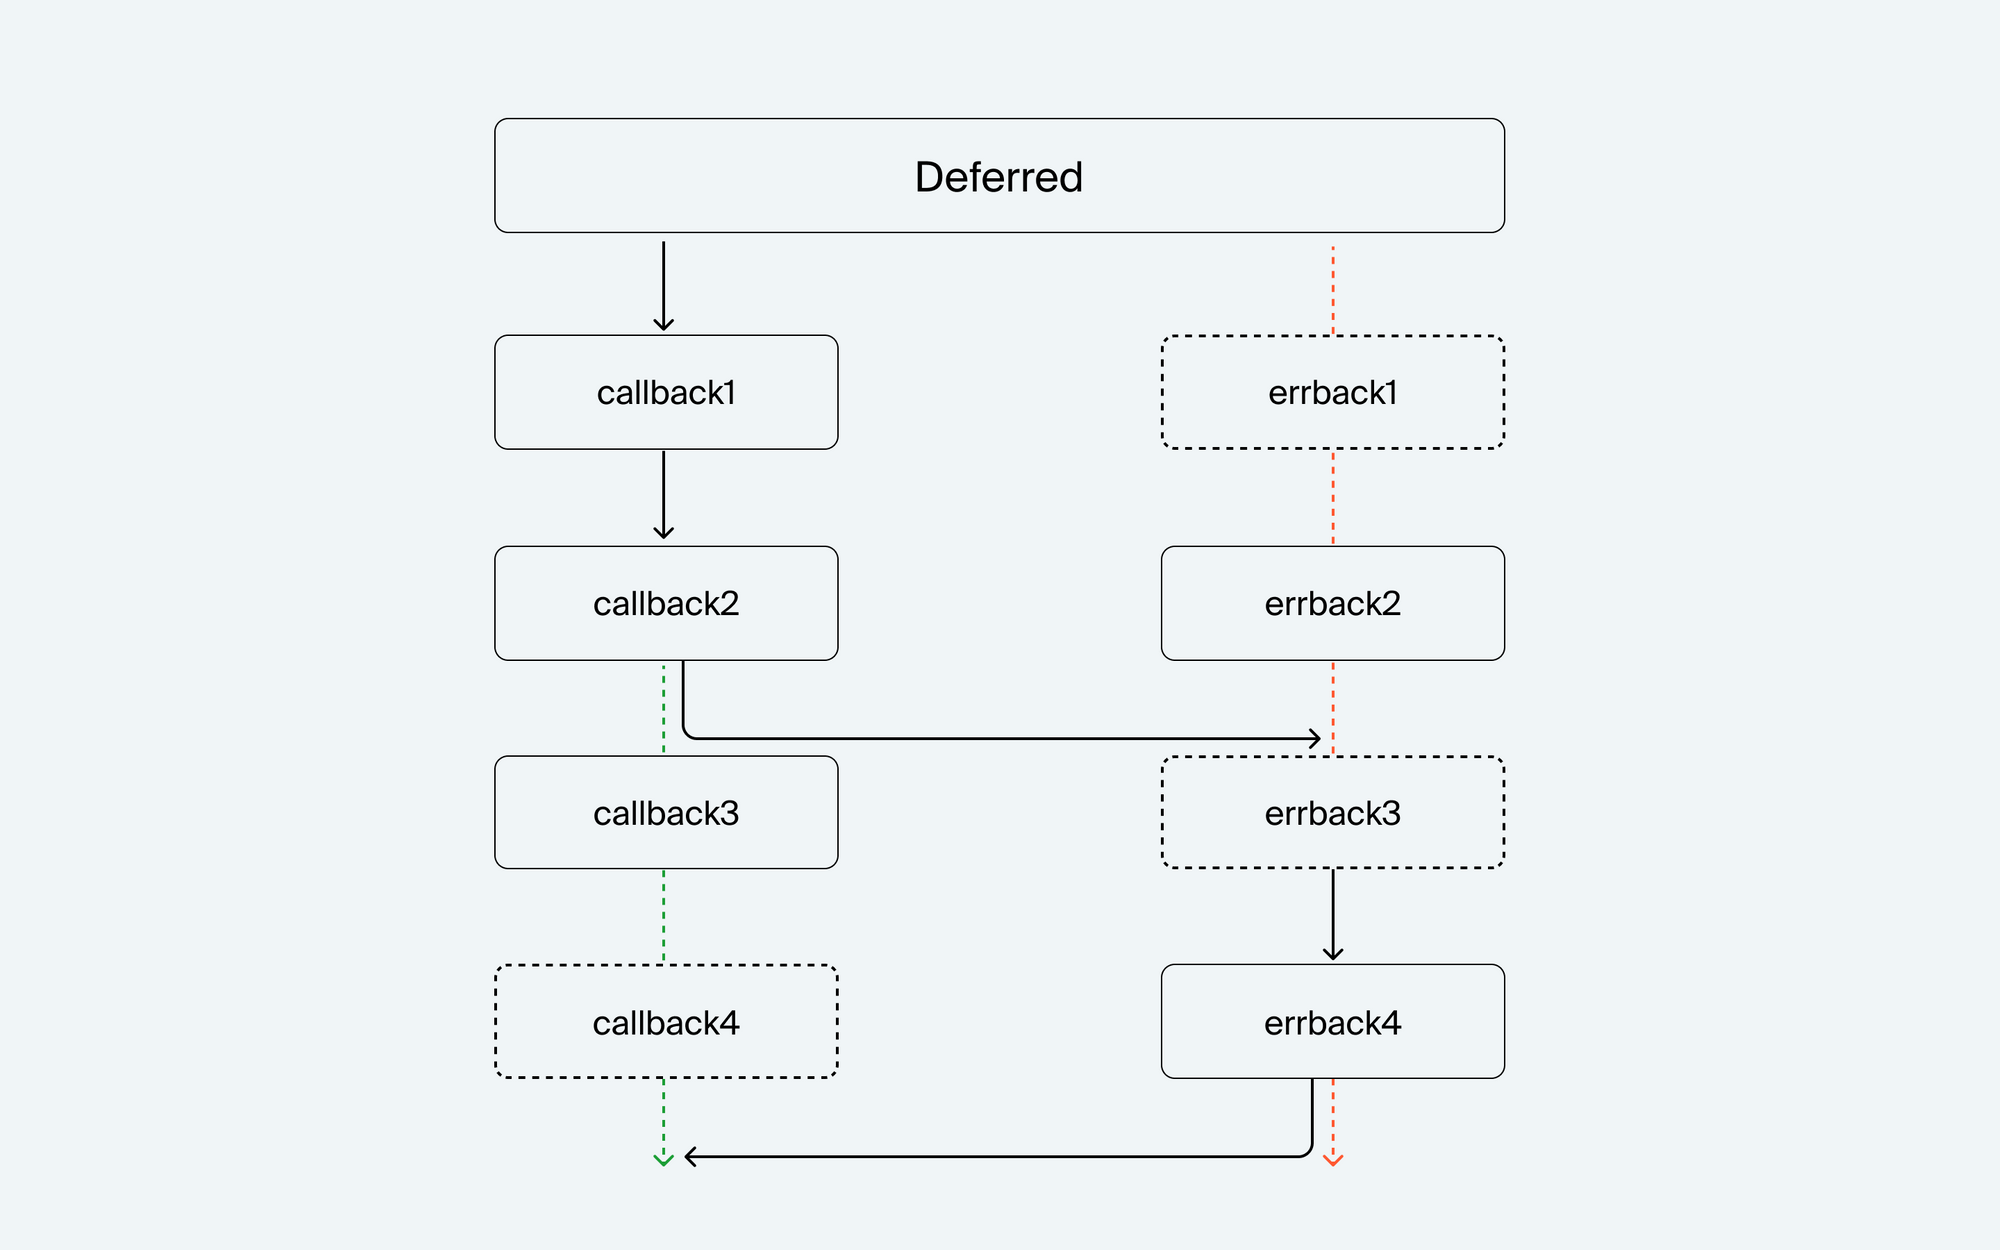

#### Особенности

- На Twisted основано много подпроектов для создания приложений, например, веб-сервера, почтового сервера, DNS или Email.
- Вы можете сделать из своего приложения плагин для командной строки.
- Twisted обладает [собственным модулем для тестирования](http://twistedmatrix.com/documents/current/core/howto/testing.html) и [системой логирования](https://twistedmatrix.com/documents/current/core/howto/logging.html).
- Twisted лучше подходит для низкоуровневых сетевых взаимодействий, чем для обычных веб-приложений.

### AIOHTTP

#### Последствия стандартизации

После того как в Python появились волшебные слова `await` и `async`, была создана библиотека `aiohttp`. Это асинхронные HTTP-клиент и сервер, который построен поверх `asyncio` со встроенной поддержкой клиентских и серверных веб-сокетов.

Например, приложение, которое выводит заглавными буквами на главной странице случайную фразу, может выглядеть так:

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
import aiohttp
from aiohttp import web

async def get_phrase():
    # Метод, который обращается к стороннему ресурсу и забирает данные
    async with aiohttp.ClientSession() as session:
        async with session.get('https://fish-text.ru/get', params={'type': 'title'}) as response:
            result = await response.json(content_type='text/html; charset=utf-8')
            return result.get('text')


async def index_handler(request):
    return web.Response(text=await get_phrase())  # Формируем ответ для клиента


async def response_signal(request, response):
    response.text = response.text.upper()  # Увеличиваем все буквы в ответе
    return response


async def make_app():
    app = web.Application()  # Объявляем приложение — ваш веб-сервер
    app.on_response_prepare.append(response_signal)  # Добавим сигнал
    app.add_routes([web.get('/', index_handler)])  # Добавим необходимый URL
    return app


web.run_app(make_app())  # Запускаем приложение

Вы могли заметить, что структура приложения гораздо проще, чем у Twisted. Сравните реализации протокола: в Twisted вы должны описать три отдельных метода на каждое событие, и держать в памяти, когда вызывается каждый из них, и какие Deffered-цепочки в них задействованы. В aiohttp код пишется линейно и в нём нет коллбэков. Благодаря простоте кода и отличной документации aiohttp быстро обрёл популярность.

#### Особенности

- У `aiohttp` есть много функций для комфортной разработки асинхронного веб-приложения. Например, он поддерживает jinja-шаблоны и раздачу статических файлов, а также у него есть middlewares, пользовательские сессии и debugtoolbar.
- Его можно расширять почти до бесконечности с помощью множества библиотек, которые можно найти в [GitHub](https://github.com/aio-libs) или в [одной из подборок](https://github.com/maximdanilchenko/aiohttp-apispec).
- Сущности router и views построены как в популярных синхронных фреймворках. Вы можете писать обработчики как функции или классы, использовать Class Based Views, выносить роутер в отдельный файл, как в Django, или использовать декораторы, как во Flask.
- Вы можете декомпозировать ваш сервер на [несколько приложений](https://docs.aiohttp.org/en/stable/web_advanced.html#nested-applications).

### FastAPI

#### Фреймворк для ленивых

FastAPI — самый молодой среди рассматриваемых асинхронных фреймворков. Название говорит само за себя: он создан для быстрой разработки API на Python. В его основе лежат веб-фреймворк [Starlette](https://www.starlette.io/), использующий `asyncio`, и библиотека для валидации данных [Pydantic](https://pydantic-docs.helpmanual.io/).

Fast API досталась от Starlette классическая функциональность веб-фреймворка:

- работа с Websocket,
- фоновые задачи,
- клиент для тестирования,
- централизованная обработка исключений,
- встроенная поддержка GraphQL,
- поддержка пользовательских сессий и Cookie,
- и прочие необходимые способности.

Pydantic отвечает за валидацию API при помощи встроенной в Python аннотации типов. Кроме встроенных типов, Pydantic обзавёлся своими, например, `Color` для цветов в css, а ещё `Json`, `AnyUrl` или `UUID5`.

В результате этого союза получился быстрый (как по скорости работы, так и по написанию кода) фреймворк, со встроенной автоматической валидацией и сериализацией данных на основе описанных моделей. Ещё он умеет авторизировать пользователя через JWT, api-key или OAuth2 и самостоятельно генерировать документацию!

Благодаря строгой типизации во фреймворке есть встроенная генерация OpenAPI-файла. После запуска приложения вы получите готовую документацию для вашего API и интерфейс для её просмотра. К сожалению, в обратную сторону это не работает: по OpenAPI-файлу нельзя получить готовый API, поэтому придётся писать его самостоятельно :(

Ещё одна отличительная способность FastAPI — поддержка [внедрения зависимостей](https://fastapi.tiangolo.com/tutorial/dependencies/). Это делает код более гибким: вы можете переиспользовать нужные наборы параметров в разных частях приложения. А ещё ваши зависимости могут тоже иметь зависимости :)

В качестве примера рассмотрим реализацию API, которое складывает два числа.

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from pydantic.fields import Field

# Объявляем приложение и задаём ему название, которое будет отображаться в документации
app = FastAPI(title="Простые математические операции")


# Объявляем модель, которая будет валидировать данные, поступающие от пользователя
# При несовпадении данных со схемой пользователю вернётся ошибка валидации
class Add(BaseModel):
    first_number: int = Field(title='Первое слагаемое')
    second_number: int | None = Field(title='Второе слагаемое')


# Объявляем модель для формирования результата
# При несовпадении данных со схемой вы получите подробный traceback :)
class Result(BaseModel):
    result: int = Field(title='Результат')


# Добавляем URL и привязываем к нему модели запроса и ответа
@app.post("/add",  response_model=Result)
async def create_item(item: Add):
    # Выполняем вычисления
    return {
        'result': item.first_number + item.second_number or 1
    }

Магическая команда `save` сохраняет ячейку в указанный файл

In [ ]:
%save fastapi_example.py 5

Загрузка файла в ячейку

In [ ]:
%load fastapi_example.py

#### Особенности

- Если вы используете `exception_handler` для оповещения пользователя об ошибках, магия автогенерации документации не сработает: Swagger не будет знать о новых вариантах ответа. Вам придётся дополнить OpenAPI вручную.
- FastAPI не ограничивает вас в дизайне архитектуры приложения. Например, вы можете указывать структуру тела запроса в аргументах обработчика или вынести их в отдельную модель.
- Событий, на которые можно повесить сигналы, довольно мало: FastAPI при старте и завершении работы приложения.

Фреймворк заточен для написания API, прост в освоении и обладает широким набором возможностей.